<a href="https://colab.research.google.com/github/gustavoramos82/Custo-de-Seguro-Sa-de/blob/main/Medical_Cost_Personal_Crisp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimando Seguro de Sáude

Neste notebook, será feito um entendimento sobre os custos do seguro de saúde a partir de um dataset obtido no kaggle (pode ser acessado [aqui](https://www.kaggle.com/datasets/mirichoi0218/insurance?select=insurance.csv) , fazendo um entendimento do negócio, e partir disso, criar um modelo de machine learning que tenha uma melhor estimativa acerca dos preços.

In [ ]:
# Importando os módulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def rmse(y_teste, y_pred):
  rmse = np.sqrt(mean_squared_error(y_teste,y_pred))
  return rmse

## Esquema do Crisp
![esquema](https://2315530342-files.gitbook.io/~/files/v0/b/gitbook-x-prod.appspot.com/o/spaces%2Fb66bdV3JnCYJ5yeWf5dy%2Fuploads%2Fgit-blob-e3eea337334d513c6bceedd362fbd336cd41817d%2Fcrisp_dm.drawio.png?alt=media)

## Etapa 1-Entendimento do negocio

O problema deste dataset, segundo diz no link do kaggle é, a partir de um modelo de machine learning pode predizer os custos do seguro.

## Etapa 2 - Entendimento dos Dados

In [ ]:
# Importando o arquivo csv
med = pd.read_csv('insurance.csv')
med.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Para entender melhor o que representa data coluna, segue o dicionario de dados para o melhor entendimento:

Dicionário dos dados:

**age** - Idade do beneficiário primário.

**sex** - genero que contratou o seguro.

**bmi** - indice de massa corporal.

**children** - número de crianças cobridas pelo seguro.

**smoker** - Se fuma (sim ou não).

**region** - Área residencial que o beneficiario mora nos Estados Unidos.

**charges** - Custos médicos individuais por seguro seguro de saúde.

Para ficar mais fácil, as variaveis sex e smoker serão transformados em dados categoricos.

In [ ]:
med['sex'] = med['sex'].map({'female':0,'male':1})
med['smoker'] = med['smoker'].map({'no':0,'yes':1})

In [ ]:
med.head() 
# no caso da variavel region, sera verificado na analise se melhor tranformar em variavel dummie ou desconsiderar a mesma.

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [ ]:
med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(4), object(1)
memory usage: 73.3+ KB


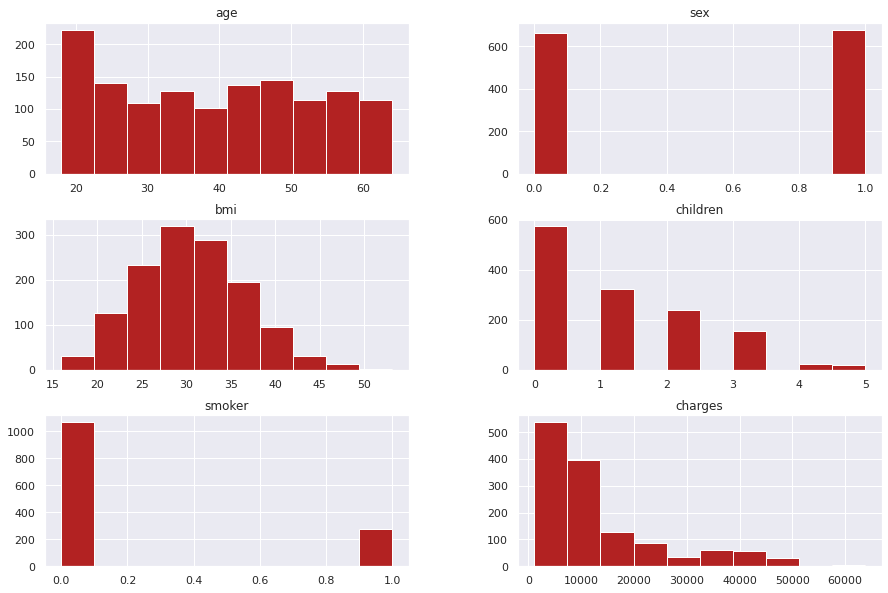

In [ ]:
# Verificando a distribuição das variaveis
sns.set(style='darkgrid',rc={'figure.figsize':(15,10)})
med.hist(color='firebrick');

Olhando os dados acimas, temos que

- a maioria das pessoa dataset é formado por fumantes;
- cerca de 600 pessoas não tem filhos;
- As idades tem mais idade por volta de 20 a 30 anos tem mais quantidade.
- e o preço dos custo estão por volta de 10 mil

- A partir desse tabela de imc (fonte [aqui](https://www.saudenaosepesa.com.br/diagnostico.html?utm_source=g-search&utm_medium=cpc&utm_content=texto&utm_term=normal&utm_campaign=ogilvybr_novo-nordisk_always-on-performance_g-search_cliques_202205_texto_cpc_calcule-imc&gclid=Cj0KCQjw2MWVBhCQARIsAIjbwoM_742If-6JDY6FZdC8b-cUypjydzxEYzI0v0AC1zBoeQtkfmb6vTkaAjCcEALw_wcB)) temos que a maioria das pessoas tem sobrepeso e obesidade.

![imc](https://i.ibb.co/8B1zRLc/2022-06-21-21-17.png)


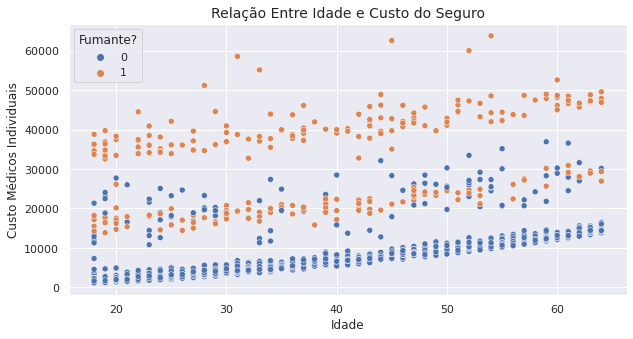

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Relação Entre Idade e Custo do Seguro',fontsize=14)
sns.scatterplot(x='age',y='charges',data=med,hue='smoker')
plt.xlabel('Idade')
plt.ylabel('Custo Médicos Individuais')
plt.legend(title='Fumante?')

A idade parece não ter muita relação com o preço mas, uma fato importante foi observado, abaixo de 10 mil, só temos pessos não fumantes, e a partir de 30 mil só tem pessoas fumantes, então a variavel fumante deve ser um fator importante que consideram no preço

Text(0, 0.5, 'Custo')

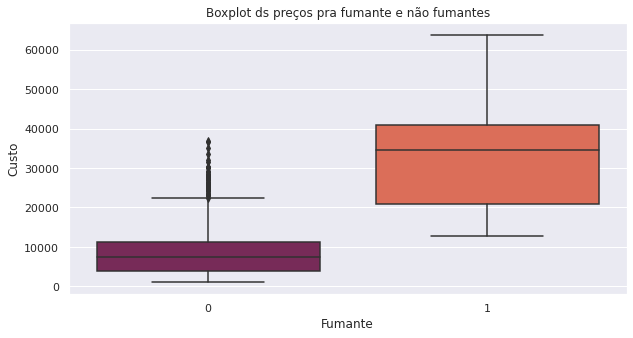

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Boxplot ds preços pra fumante e não fumantes')
sns.boxplot(x='smoker',y='charges',data=med,palette='rocket')
plt.xlabel('Fumante')
plt.ylabel('Custo')


Podemos ver nesse gráfico de boxplot q realment se a pessoa é fumantes, o custo vai ser mais caro.

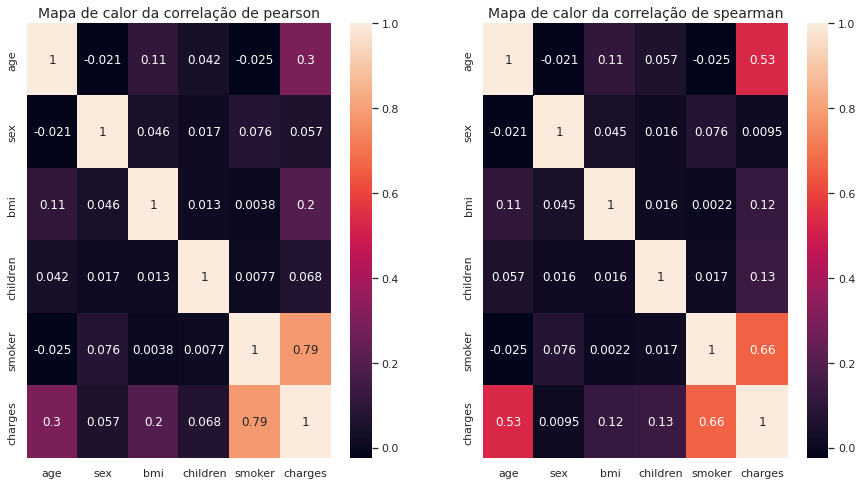

In [ ]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.title('Mapa de calor da correlação de pearson',fontsize=14)
pearson = med.corr(method='pearson')
sns.heatmap(pearson,annot=True)

plt.subplot(1,2,2)
plt.title('Mapa de calor da correlação de spearman',fontsize=14)
spearman = med.corr(method='spearman')
sns.heatmap(spearman,annot=True)

podemos ver pelas correlaões que variaveis importantes são skmoke e a age, enquanto as outras não temos uma correlação muito forte

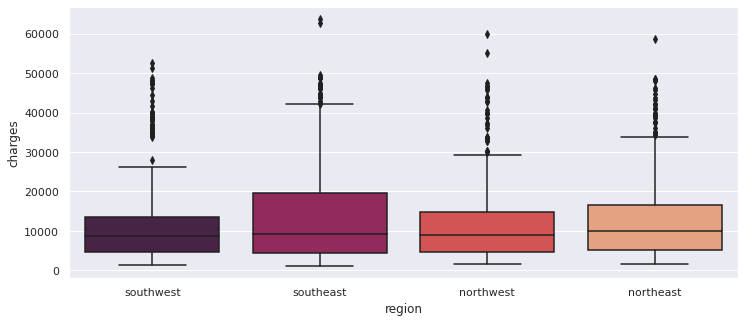

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x='region',y='charges',data=med,palette='rocket')

Text(0, 0.5, 'Região')

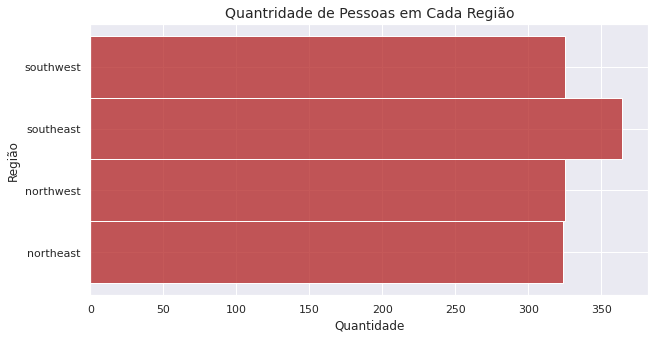

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Quantridade de Pessoas em Cada Região',fontsize=14)
sns.histplot(y='region',data=med,color='firebrick')
plt.xlabel('Quantidade')
plt.ylabel('Região')

podemos ver pelos grafico de boxplot e barras e de correlação que a região não tem um efeito nos target, então a mesma será desconsiderada.

## Etapa 3 - Preparação do Dados

In [ ]:
#Verificando se tem valores nulos
med.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [ ]:
#retirando a variavel region
med.drop('region',axis=1,inplace=True)

## Etapa 4 - Modelagem

In [ ]:
x = med.drop('charges',axis=1).values
y = med.charges.values

x_std = StandardScaler().fit_transform(x)


In [ ]:
med.shape

(1338, 6)

In [ ]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x_std,y,test_size=0.25,random_state=10)

Testando a regressão linear

In [ ]:
rl = LinearRegression()
rl.fit(x_treino,y_treino)
y_rl = rl.predict(x_teste)

In [ ]:
print('regressão linear')
print('R2 score',r2_score(y_teste,y_rl))
print('MAE',mean_absolute_error(y_teste,y_rl))
print('RMSE',rmse(y_teste,y_rl))
print('MAPE',mean_absolute_percentage_error(y_teste,y_rl))

regressão linear
R2 score 0.7153639826310381
MAE 4292.04804494192
RMSE 6186.54535316029
MAPE 0.4557253232581794


KNN

In [ ]:
knn = KNeighborsRegressor(n_neighbors=11)
knn.fit(x_treino,y_treino)
y_knn = knn.predict(x_teste)

In [ ]:
print('KNN')
print('R2 score',r2_score(y_teste,y_knn))
print('MAE',mean_absolute_error(y_teste,y_knn))
print('RMSE',rmse(y_teste,y_knn))
print('MAPE',mean_absolute_percentage_error(y_teste,y_knn))

KNN
R2 score 0.8236156026749483
MAE 2910.02819280597
RMSE 4870.049290003297
MAPE 0.3075570207584924


Árvore de Decisão

In [ ]:
tree = DecisionTreeRegressor()
tree.fit(x_treino,y_treino)
y_tree = tree.predict(x_teste)

In [ ]:
print('àrvore de Decisão')
print('R2 score',r2_score(y_teste,y_tree))
print('MAE',mean_absolute_error(y_teste,y_tree))
print('RMSE',rmse(y_teste,y_tree))
print('MAPE',mean_absolute_percentage_error(y_teste,y_tree))

àrvore de Decisão
R2 score 0.6403027403908332
MAE 3438.4926284477615
RMSE 6954.594913098037
MAPE 0.3960174905194917


Random Forest

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_treino,y_treino)
y_rf = rf.predict(x_teste)

In [ ]:
print('Random forest')
print('R2 score',r2_score(y_teste,y_rf))
print('MAE',mean_absolute_error(y_teste,y_rf))
print('RMSE',rmse(y_teste,y_rf))
print('MAPE',mean_absolute_percentage_error(y_teste,y_rf))

Random forest
R2 score 0.8228165110079224
MAE 2720.181558812
RMSE 4881.0684566010395
MAPE 0.3137347217352288


Gradiente Boosting

In [ ]:
grad = GradientBoostingRegressor(criterion='mse')
grad.fit(x_treino,y_treino)
y_grad = grad.predict(x_teste)

In [ ]:
print('Gradiente Boosting')
print('R2 score',r2_score(y_teste,y_grad))
print('MAE',mean_absolute_error(y_teste,y_grad))
print('RMSE',rmse(y_teste,y_grad))
print('MAPE',mean_absolute_percentage_error(y_teste,y_grad))

Gradiente Boosting
R2 score 0.8449829372954507
MAE 2526.986080353414
RMSE 4565.549184264583
MAPE 0.3055769612806073


In [ ]:
resultados = {'Modelo':['Regressão Linear','KNN','Árvore de decisão','Random Forest','Gradiente Boosting'],
              'R2 score':[r2_score(y_teste,y_rl),r2_score(y_teste,y_knn),r2_score(y_teste,y_tree),r2_score(y_teste,y_rf),
                          r2_score(y_teste,y_grad)],
              'MAE':[mean_absolute_error(y_teste,y_rl),mean_absolute_error(y_teste,y_knn),mean_absolute_error(y_teste,y_tree),
                     mean_absolute_error(y_teste,y_rf),mean_absolute_error(y_teste,y_grad)],
              'RMSE':[rmse(y_teste,y_rl),rmse(y_teste,y_knn),rmse(y_teste,y_tree),rmse(y_teste,y_rf),rmse(y_teste,y_grad)],
              'MAPE':[mean_absolute_percentage_error(y_teste,y_rl),mean_absolute_percentage_error(y_teste,y_knn),
                      mean_absolute_percentage_error(y_teste,y_tree),mean_absolute_percentage_error(y_teste,y_rf),
                      mean_absolute_percentage_error(y_teste,y_grad)]
              }
resultados = pd.DataFrame(resultados)

## Etapa 5 - Avaliação

Os resultados encontrados encontrados foram os seguintes:
- A variavel smoker é a variavel mais importante do dataset para fazer a estimativa do custo, como pode ser visto no gráfico abaixo, além de q se olharmos por intervalor diferentes dos custos, a idade também tem influência de certa forma.

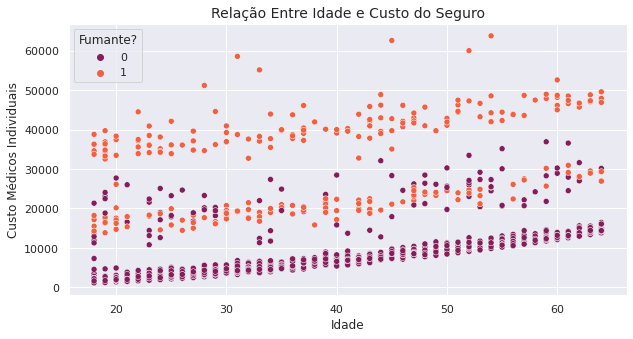

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Relação Entre Idade e Custo do Seguro',fontsize=14)
sns.scatterplot(x='age',y='charges',data=med,hue='smoker',palette='rocket')
plt.xlabel('Idade')
plt.ylabel('Custo Médicos Individuais')
plt.legend(title='Fumante?');

A variavel região nã tem tanta influência nos preços, então a mesma não foi consaiderada.

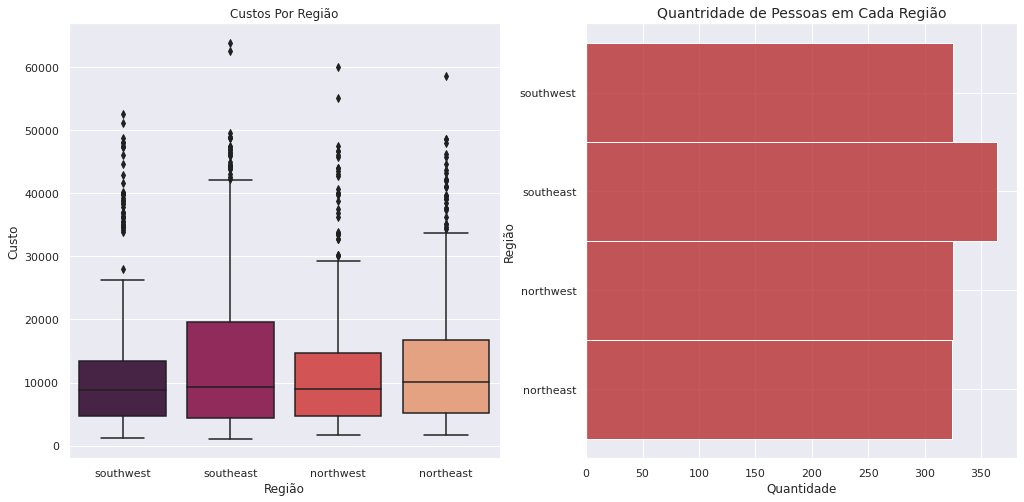

In [ ]:
med2 = pd.read_csv('insurance.csv')
plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.title('Custos Por Região')
sns.boxplot(x='region',y='charges',data=med2,palette='rocket')
plt.xlabel('Região')
plt.ylabel('Custo')

plt.subplot(1,2,2)
plt.title('Quantridade de Pessoas em Cada Região',fontsize=14)
sns.histplot(y='region',data=med2,color='firebrick')
plt.xlabel('Quantidade')
plt.ylabel('Região');

E a mairio das pessoa deste dataset é sobrepeso ou obesa.

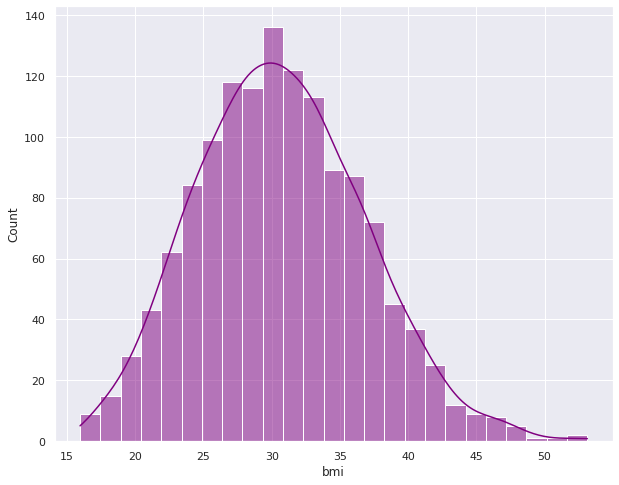

In [ ]:
plt.figure(figsize=(10,8))
sns.histplot(x='bmi',data=med,color='purple',kde=True)

Dentre os modelos abaixo, a que teve melhor perfomace foi o *Gradiente Boosting* então esse é o que será usado.

In [ ]:
resultados

,Modelo,R2 score,MAE,RMSE,MAPE
0,Regressão Linear,0.715364,4292.048045,6186.545353,0.455725
1,KNN,0.823616,2910.028193,4870.049290,0.307557
2,Árvore de decisão,0.640303,3438.492628,6954.594913,0.396017
3,Random Forest,0.822817,2720.181559,4881.068457,0.313735
4,Gradiente Boosting,0.844983,2526.986080,4565.549184,0.305577


Podemos ver abaixo no gráfico a esquerda que o modelo tem uma boa perfomace, mas como posso ser visto no histograma ao lado que tem muito valores próximos a 10 mil, o modelo tende a estimar valores pŕóximos a este, assim, necessitando de uma coleta  de dados com valores maiores a 10 mil para que asim o modelo possa ter uma melhora na estimativa

Text(0, 0.5, 'Quantidade')

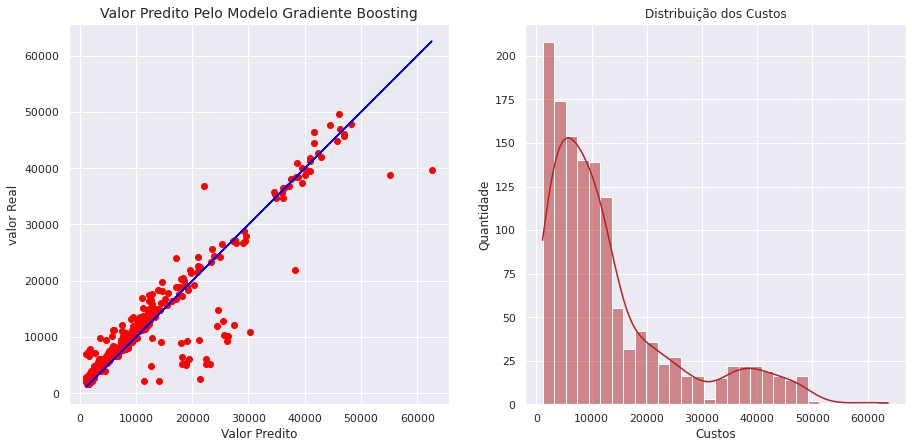

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.title('Valor Predito Pelo Modelo Gradiente Boosting',fontsize=14)
plt.plot(y_teste,y_teste,color='blue')
plt.scatter(y_teste,y_grad,color='red')
plt.xlabel('Valor Predito')
plt.ylabel('valor Real')

plt.subplot(1,2,2)
plt.title('Distribuição dos Custos')
sns.histplot(x='charges',color='firebrick',data=med,kde=True)
plt.xlabel('Custos')
plt.ylabel('Quantidade')